# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from datetime import datetime, timedelta

import pickle

import copy
import os

import warnings

warnings.filterwarnings('ignore')

In [212]:
cwd = os.getcwd()

PATH_SALES_DF_TRAIN = cwd + '/data/raw/sales_df_train.csv'
PATH_PR_DF = cwd + '/data/raw/pr_df.csv'
PATH_ST_DF = cwd + '/data/raw/st_df.csv'
PATH_TO_SUMISSION_DF = cwd + '/data/raw/sales_submission.csv'

PATH_TO_SAVE_HOLIDAYS = cwd + '/data/holidays.csv'

PATH_TO_SAVE_TRAIN_DF = cwd + '/data/preprocessing/preproc_df_train.csv'
PATH_TO_SAVE_TEST_DF = cwd + '/data/preprocessing/test.csv'
PATH_TO_SAVE_TRAIN_TEST_DF = cwd + '/data/preprocessing/train_test.csv'

PATH_TO_SAVE_SUMISSION_DF = cwd + '/data/submission/sales_submission.csv'

PATH_TO_SAVE_MODELS = cwd + '\\models\\model.pkl'


Создадим функцию для оценки качества, поскольку нужно будет оценивать качество как на широкой таблице, так и на узкой, то пропишем доп обработку входных значений.

In [3]:
def wape(y_true: np.array, y_pred: np.array):
    if type(y_true) == pd.DataFrame:
        y_true = y_true.values.reshape(-1)
    elif type(y_true) != pd.Series:
        y_true = y_true.reshape(-1)
        
    if type(y_pred) == pd.DataFrame:
        y_pred = y_pred.values.reshape(-1)
    elif type(y_pred) != pd.Series:
        y_pred = y_pred.reshape(-1)
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

Поскольку нам нужно минимизировать наше значение, то преобразуем нашу функциюю в loss (для оптимизации в GridSearch)

In [4]:
wape_loss = make_scorer(wape, greater_is_better=False)

Так как нам нужно обучить разные модели на разных товарах, то будем создавать словарь с моделями, которые проверим на необработанных данных, которые модель не видела

## Создание baislain

Создадим наивную модель. Для начала откроем сырые данные

In [5]:
df_y_test = pd.read_csv(PATH_TO_SAVE_TRAIN_DF)[['pr_sku_id', 'st_id', 'target', 'date']]
df_y_test = df_y_test.rename(columns={'target': 'y_true'})

Проведём аггрегацию по пересекающимся полям, что бы продукт для каждой даты встречался один раз (с разбиением на промо и без

In [6]:
df_y_test['date'] = pd.to_datetime(df_y_test['date'])
df_y_test = df_y_test.sort_values('date')

Для того, чтобы можно было чисто протестировать потом модель отложим последние 28 дней (14 на тест, 14 на валидацию).

In [7]:
last_date = df_y_test['date'].max()
first_date = last_date - timedelta(days=28)
valid_start_date = last_date - timedelta(days=14)

In [8]:
first_date, valid_start_date, last_date

(Timestamp('2023-06-20 00:00:00'),
 Timestamp('2023-07-04 00:00:00'),
 Timestamp('2023-07-18 00:00:00'))

Получим данные для даты идущей перед валидационным отрезком

In [9]:
df_in_date = df_y_test.loc[df_y_test['date']=='2023-06-19']

Последующие 14 дней будем предсказывать по последней известной цене

In [10]:
list_df = []
for d in range(0, 14):
    date = first_date + timedelta(days=d)
    df = df_in_date.copy(deep=True)
    df['date'] = date
    df = df.rename(columns={'y_true': 'target'})
    list_df.append(df)
    
predict_df = pd.concat(list_df, axis=0)

In [11]:
predict_df

,pr_sku_id,st_id,target,date
301955,d22bb534b7964c0cafab6aab1995f000,c81e728d9d4c2f636f067f89cc14862c,5.0,2023-06-20
301954,d084272630b1d93f436019a35461f1ee,c81e728d9d4c2f636f067f89cc14862c,4.0,2023-06-20
301953,cfb54b1ce12bb3f9b6b9e2ea0b57414b,c81e728d9d4c2f636f067f89cc14862c,0.0,2023-06-20
301952,cf91eca9321c9c272fb4e7cf4bcc6a43,c81e728d9d4c2f636f067f89cc14862c,14.0,2023-06-20
301951,ced0c1a84924c982a6403870c54b99ca,c81e728d9d4c2f636f067f89cc14862c,14.0,2023-06-20
...,...,...,...,...
301435,adf3f8d0e45cd2e4cfb284e1eaddc5c8,42a0e188f5033bc65bf8d78622277c4e,0.0,2023-07-03
301434,ab7ea17fa5084296d422820744b1e2cd,42a0e188f5033bc65bf8d78622277c4e,1.0,2023-07-03
301433,a9fc8e69fb59a5e3edda06e56129b1e6,42a0e188f5033bc65bf8d78622277c4e,1.0,2023-07-03
301440,b43e19936412e99b8efd1f9061d3f3c7,42a0e188f5033bc65bf8d78622277c4e,2.0,2023-07-03


Получим данные по тестовым данным за указанный диапазон

In [12]:
df_test_true = df_y_test.loc[(df_y_test['date']>=first_date) &
                             (df_y_test['date']<valid_start_date)]

Объединим датасеты И заполним любые пропуски нулями

In [13]:
df_test_true = df_test_true.merge(predict_df, on=['date', 'pr_sku_id', 'st_id'], how='outer')
df_test_true = df_test_true.fillna(0)

Посмотрим на метрику наивной модели

In [14]:
wape(df_test_true['y_true'], df_test_true['target'])

0.7837401110924087

Визуализируем полученный прогноз

In [15]:
def visualize_pred(df, name_plot_model, name_pred_column = 'target', name_true_column = 'y_true'):
    df = df.groupby('date')[['target', 'y_true']].agg('sum')
    plt.figure(figsize=(10, 6))
    plt.title(f'График прогноза и реальных значений (сумма всех заказов по дате) для модели {name_plot_model}')
    plt.plot(df[name_true_column], label='test')
    plt.plot(df[name_pred_column], label='prediction')
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlabel('Дата')
    plt.ylabel('Количество проданных товаров')
    plt.show()

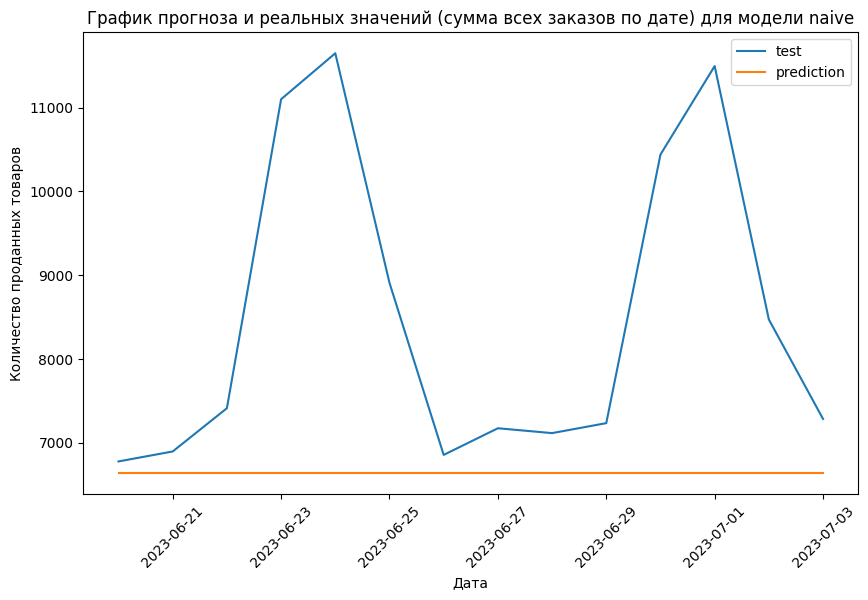

In [16]:
visualize_pred(df_test_true, 'naive')

Это будет нашим безлайном, который мы попробуем побить

## Создание моделей

Получим данные для тренировки, теста и проверки предикта

In [17]:
df_train = pd.read_csv(PATH_TO_SAVE_TRAIN_DF, parse_dates=['date'], index_col='date')
df_train = df_train.loc[: first_date - timedelta(days=1)]

df_test = pd.read_csv(PATH_TO_SAVE_TRAIN_DF, parse_dates=['date'], index_col='date')
df_test = df_test.loc[first_date: valid_start_date - timedelta(days=1)]

df_test_true = df_y_test.loc[(df_y_test['date']>=first_date) &
                             (df_y_test['date']<valid_start_date)]

Создадим список категориальных признаков

In [18]:
cat_columns = ['st_id', 'pr_sku_id', 'st_city_id', 'st_division_code',
       'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'mean_seale',
       'pr_uom_id', 'group_shop_cat']

Для ускорения расчётов проверять будем с количеством выборщиков равным 300

In [19]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target'] 

model = CatBoostRegressor(random_state=123,
                          cat_features=cat_columns,
                          n_estimators = 300,
                          thread_count = -1,
                          verbose=100)

model.fit(X_train, y_train)

Learning rate set to 0.268674
0:	learn: 9.2980240	total: 323ms	remaining: 1m 36s
100:	learn: 4.5684583	total: 14.5s	remaining: 28.7s
200:	learn: 4.0756055	total: 28.4s	remaining: 14s
299:	learn: 3.8111100	total: 42s	remaining: 0us


In [20]:
new_df = df_test[['pr_sku_id', 'st_id']].reset_index(drop=True)
new_df['date'] = df_test.index

y_pred = model.predict(df_test.drop('target', axis=1))
new_df['target'] = y_pred

In [21]:
new_df = new_df.merge(df_test_true, on=['date', 'pr_sku_id', 'st_id'], how='right')
new_df = new_df.fillna(0)

In [22]:
wape(new_df['y_true'], new_df['target'])

0.46074250189971055

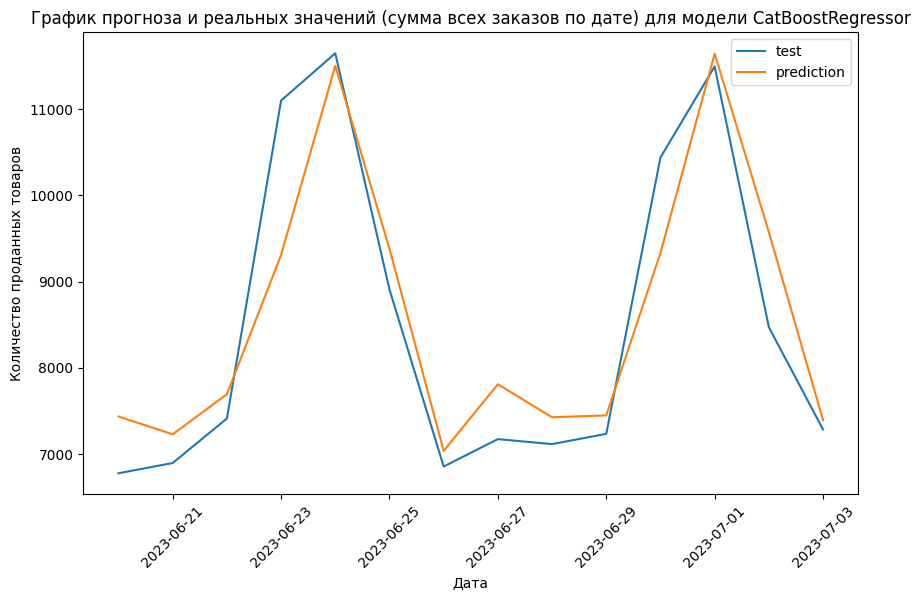

In [23]:
visualize_pred(new_df, 'CatBoostRegressor')

## Проверка гипотезы о разделение моделей для прогноза

У нас есть гипотеза, что качество модели можно улучшить разделив первоначальные данные по группам магазинов и категориям товаров, исходя из графического анализа. Проверим данную гипотезу. Для этого нам потребуется создать функцию, которая будет обучать модели и сохранять их в словарь.

In [24]:
def fit_models(df, model):
    dict_mod = {}
    list_mod = df['group_shop_cat'].unique()
    for name_mod in tqdm(list_mod):
        df_train_mod = df[df['group_shop_cat'] == name_mod].copy(deep=True)
        if df_train_mod.shape[0] > 1:
            X_train = df_train_mod.drop('target', axis=1)
            X_train = X_train.drop('group_shop_cat', axis=1)
            y_train = df_train_mod['target'] 

            new_model = copy.deepcopy(model)
            new_model.fit(X_train, y_train)
            dict_mod[name_mod] = new_model
    return dict_mod

Поскольку выбор модели осуществляется на основании стобца group_shop_cat, то уберём его из категориальных столбцов

In [25]:
new_cat_columns = [*cat_columns]
new_cat_columns.remove('group_shop_cat')

In [26]:
%%time
model = CatBoostRegressor(random_state=123,
                          cat_features=new_cat_columns,
                          n_estimators = 300,
                          allow_const_label=True,
                          thread_count = -1,
                          verbose=False)
dict_mod = fit_models(df_train, model)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:30<00:00,  3.60s/it]

CPU times: total: 7min 58s
Wall time: 1min 30s


Напишем функцию для прогноза, которая будет принимать на вход датасет и словарь с моделями и возвращать готовый датасет с предиктом

In [27]:
def pred_models(df, dict_model):
    dict_pred = {}
    for name_mod in dict_model.keys():
        df_train_mod = df[df['group_shop_cat'] == name_mod].copy(deep=True)
        df_train_mod =  df_train_mod.drop('group_shop_cat', axis=1)
       
        new_df = df_train_mod[['pr_sku_id', 'st_id']].reset_index(drop=True)
        new_df['date'] = df_train_mod.index
        y_pred = dict_model[name_mod].predict(df_train_mod.drop('target', axis=1))
        new_df['target'] = y_pred
        dict_pred[name_mod] = new_df
        
    return pd.concat(dict_pred.values(),axis=0).sort_values(['date','st_id', 'pr_sku_id'])

In [28]:
df_pred = pred_models(df_test, dict_mod)

In [29]:
df_pred = df_pred.merge(df_test_true, on=['date', 'pr_sku_id', 'st_id'], how='right')

In [30]:
wape(df_pred['y_true'], df_pred['target'])

0.4527463803668444

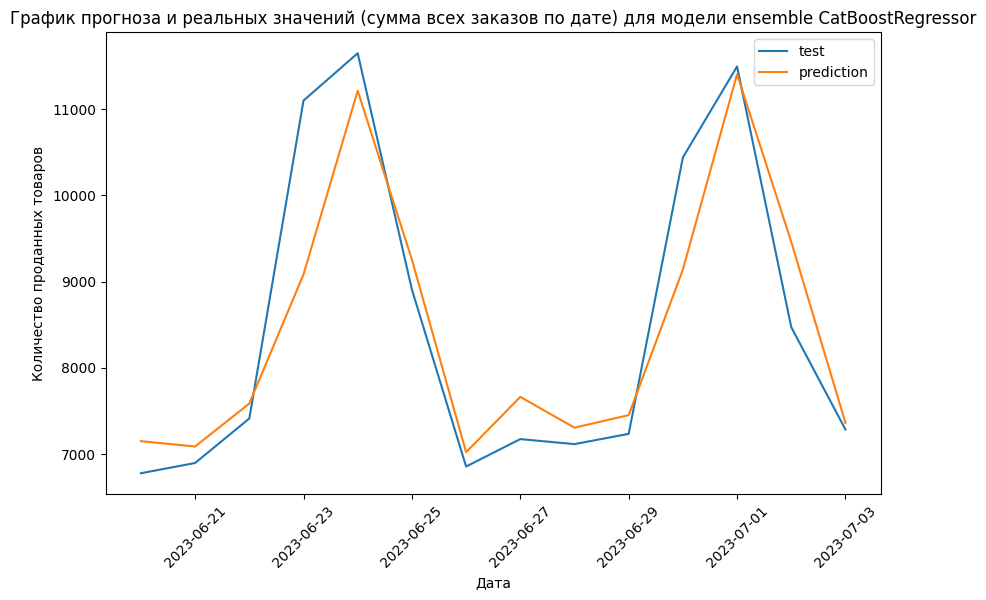

In [31]:
visualize_pred(df_pred, 'ensemble CatBoostRegressor')

Как видим качество прогноза улучшилось незначительно, поэтому будем использовать обычный кэтбуст, он вполне неплохо справляется с поставленной задачей.

## Оптимизация признаков

Попробуем улучшить качество нашей модели путем подбора оптимальных признаков для этого воспользуемся функциями разработанными на этапе предообработки данных.

In [32]:
def get_clear_df(df, df_date, limit_nan = 10):
    new_df = df.copy(deep=True)
    # оставим в датасете только значения с целевым признаком больше или равных 0
    new_df = new_df[new_df['pr_sales_in_units']>=0].reset_index(drop=True)
    if new_df.shape[0] > 0:
        #сделаем словарь для заполнения пропусков    
        list_col = list(new_df.columns)
        list_col.remove('pr_sales_in_units')
        dict_for_fillna = {k: new_df.loc[0, k] for k in list_col}

        # присоединим датасет с датами
        new_df = new_df.merge(df_date, on='date', how='right')
        
        new_df['pr_sales_in_units'] = new_df['pr_sales_in_units'].fillna(0)
        new_df = new_df.sort_values('date').reset_index(drop=True)
        
        # заполним пропуски, отступаем первые 60 дней (большая их часть будет отброшена за счёт пропусков в скользящих средних)
        # заполняем только первые 10 значений, чтобы модель не стремилась предсказывать везде 0
        for k, v in dict_for_fillna.items():
            new_df.loc[60:,k] = new_df.loc[60:,k].fillna(v, limit=limit_nan)
                   
    else:
        new_df = None
    
    return new_df

In [33]:
def get_date_and_weekday(df):
    #приведём дату в нужный формат, укажем новый индекс и день недели
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.weekday 
    df['weekend'] = (df['weekday'] == 5) | (df['weekday'] == 6)
    # преобразуем день недели через тригонометрическую функцию    
    df['weekday_cos'] =  np.cos((2 * np.pi) / 7 * (df['weekday'] + 1))
    # аналогично поступим с неделями
    df['week'] = df['date'].dt.isocalendar().week
    df['week'] =  np.cos((2 * np.pi) / 53 * (df['week'] + 1))
    
    df.index = df['date']
    df = df.drop('date', axis=1)

    return df

In [34]:
def get_mean_in_day(df, weekday_column, column, n_week):
    list_weekday_column = df[weekday_column].unique()
    for day in list_weekday_column: 
        new_name_mean = f'mean_in_weekday_{n_week}_week'  
        df.loc[(df[weekday_column]==day), new_name_mean] = (df[df[weekday_column]==day][column]
                                                           .shift(13).shift()
                                                           .rolling(n_week)
                                                           .mean()) 
    df = df.drop(weekday_column, axis=1)
    return df

In [35]:
def get_rolling(df, column, n_day_list):    
    for n_day in n_day_list:
        new_name_mean = f'rolling_mean_{n_day}'
        new_name_max = f'rolling_max_{n_day}'
        new_name_min = f'rolling_min_{n_day}'        
        new_name_max_min = f'rolling_max_min_{n_day}'
        new_name_ratio = f'rolling_ratio_{n_day}'     
        df[new_name_mean] = (df[column]
                               .shift(13).shift()
                               .rolling(n_day)
                               .mean())
        df[new_name_max] = (df[column]
                               .shift(13).shift()
                               .rolling(n_day)
                               .max())
        df[new_name_min] = (df[column]
                               .shift(13).shift()
                               .rolling(n_day)
                               .min())
        df[new_name_max_min] = (df[new_name_max] + df[new_name_min]) / 2
        
        df.loc[df[new_name_mean]==0, new_name_mean] = 0.001 #защита от деления на 0
        df[new_name_ratio] = df[new_name_max_min] / df[new_name_mean]
        df
    return df

In [36]:
def get_lag(df, column, n_day_list):
    for n_day in n_day_list:
        new_name = f'lag_{n_day}'
        df[new_name] = (df[column].shift(13).shift(n_day)) 
                
    df['mean_week_lag'] = df[['lag_5', 'lag_6', 'lag_7']].mean(axis=1)
    df['ratio_lag_1_to_mean_week_lag'] = df['lag_1'] / df['mean_week_lag']
    df['ratio_lag_1_to_mean_week_lag'] = df['ratio_lag_1_to_mean_week_lag'].fillna(0)
    return df

In [37]:
def get_features_ny_e_h(df, list_holidays, before_2days_holidays_list):
    #Добавим флаг нового года и пасхи
    df['new_year'] = df.index=='2023-01-01'
    df['easter'] = df.index=='2023-04-16'
    #
    df['week_after_new_year'] = (df.index > '2023-01-01') & (df.index <= '2023-01-08')
    df['week_after_easter'] = (df.index > '2023-04-16') & (df.index <= '2023-01-23')
    # Добавим флаг после нового года и пасхи
    df['week_before_new_year'] = (df.index > '2022-12-24') & (df.index < '2023-01-01')
    df['week_before_easter'] = (df.index > '2023-04-09') & (df.index <= '2023-04-16')

    #Обработаем список праздников
    df['holiday'] = df.index.isin(list_holidays)
    # получим данные о днях, которые являются двумя днями, предшествующими праздникам
    df['before_2days_holidays'] = df.index.isin(before_2days_holidays_list)
    return df

In [38]:
def get_list_before_2days_holidays(list_holidays, n_day_before=2):
    before_2days_holidays = [list_holidays[0]]
    for i in range(1, len(list_holidays)):
        last_date = datetime.strptime(list_holidays[i - 1], '%Y-%m-%d') 
        date = datetime.strptime(list_holidays[i], '%Y-%m-%d')
        if last_date != date - timedelta(days = 1):
            new_list_day_befor = []
            for i in range(1, n_day_before + 1):
                new_date = date - timedelta(days = i)
                new_date = datetime.strftime(new_date, '%Y-%m-%d')
                new_list_day_befor.append(new_date)
            before_2days_holidays += new_list_day_befor
    return before_2days_holidays

In [39]:
def rename_target(df, column):
    df = df.rename(columns = {column: 'target'})    
    return df

In [40]:
def get_dict(df, 
             df_date,
             column = 'pr_sales_in_units',
             limit_nan = 10, 
             weekday_column = 'weekday',
             n_week_for_lag = 4,
             n_day_rolling_list = [7, 14, 30],
             n_day_lag_list = list(range(1,15)),
             list_holidays = [], 
             n_day_before=2):
    #согласно тз оставим только товары без промо
    df = df[df['pr_sales_type_id']==0]
    df = df.drop('pr_sales_type_id', axis=1)
    df['st_sku'] =  df['st_id'] + '_' + df['pr_sku_id']    
    dict_df = {}    
    before_2days_holidays_list = get_list_before_2days_holidays(list_holidays, n_day_before)
    for x in df['st_sku'].unique():
        new_df = df.loc[df['st_sku']==x].copy(deep=True).reset_index(drop=True)
        new_df = get_clear_df(new_df, df_date, limit_nan)
        if not new_df is None:         
            new_df = get_date_and_weekday(new_df)  
            new_df = get_mean_in_day(new_df, weekday_column, column, n_week_for_lag)
            new_df = get_rolling(new_df, column, n_day_rolling_list)
            new_df = get_lag(new_df, column, n_day_lag_list)
            new_df = get_features_ny_e_h(new_df, list_holidays, before_2days_holidays_list)
            new_df = rename_target(new_df, column)            
            new_df = new_df.drop('st_sku', axis=1)      
            
            dict_df[x] = new_df
    
    return dict_df

In [41]:
def get_features_for_ts(df, 
                        column = 'pr_sales_in_units',
                        limit_nan = 10, 
                        weekday_column = 'weekday',
                        n_week_for_lag = 4,
                        n_day_rolling_list = [7, 14, 30],
                        n_day_lag_list = list(range(1,15)),
                        list_holidays = [], 
                         n_day_before=2):
    df = df.copy(deep = True)       
    df_date = pd.DataFrame(data=df['date'].copy(deep=True).unique(), columns=['date'])
    dict_df = get_dict(df,
                       df_date,
                       column = column,
                       limit_nan = limit_nan,
                       weekday_column = weekday_column,
                       n_week_for_lag = n_week_for_lag,
                       n_day_rolling_list = n_day_rolling_list,
                       n_day_lag_list = n_day_lag_list,
                       list_holidays = list_holidays,
                       n_day_before = n_day_before)
       
    return pd.concat(dict_df.values(),axis=0).sort_values(['date','st_id', 'pr_sku_id'])

In [42]:
def get_cat(df):
    df.loc[df['pr_cat_id']=='c559da2ba967eb820766939a658022c8', 'group_cat'] = 'cat_1'
    df.loc[df['pr_subcat_id']=='60787c41b04097dfea76addfccd12243', 'group_cat'] = 'cat_2'
    df.loc[df['pr_subcat_id']=='ca34f669ae367c87f0e75dcae0f61ee5', 'group_cat'] = 'cat_3'
    df.loc[df['pr_cat_id'].isin(['e58cc5ca94270acaceed13bc82dfedf7', 
                                          'fb2fcd534b0ff3bbed73cc51df620323']), 'group_cat'] = 'cat_4'
    df.loc[df['pr_cat_id'].isin(['3de2334a314a7a72721f1f74a6cb4cee', 
                                          'f3173935ed8ac4bf073c1bcd63171f8a',
                                          'b59c67bf196a4758191e42f76670ceba']), 'group_cat'] = 'cat_5'
    df.loc[df['pr_cat_id'].isin(['28fc2782ea7ef51c1104ccf7b9bea13d', 
                                          '9701a1c165dd9420816bfec5edd6c2b1', 
                                          '5caf41d62364d5b41a893adc1a9dd5d4', 
                                          '186a157b2992e7daed3677ce8e9fe40f', 
                                          '2df45244f09369e16ea3f9117ca45157', 
                                          '6d9c547cf146054a5a720606a7694467', 
                                          '535ab76633d94208236a2e829ea6d888', 
                                          'a6ea8471c120fe8cc35a2954c9b9c595']), 'group_cat'] = 'cat_6'
    df.loc[df['pr_cat_id']=='f9ab16852d455ce9203da64f4fc7f92d', 'group_cat'] = 'cat_7'
    df.loc[df['pr_cat_id'].isin(['b7087c1f4f89e63af8d46f3b20271153', 
                                          'f93882cbd8fc7fb794c1011d63be6fb6']), 'group_cat'] = 'cat_8'
    df.loc[df['pr_cat_id']=='faafda66202d234463057972460c04f5', 'group_cat'] = 'cat_9'
    df.loc[df['pr_cat_id']=='fd5c905bcd8c3348ad1b35d7231ee2b1', 'group_cat'] = 'cat_10'
    df.loc[df['pr_cat_id']=='c9f95a0a5af052bffce5c89917335f67', 'group_cat'] = 'cat_11'
    df['group_cat'] = df['group_cat'].fillna('cat_12')
    df['pr_uom_id'] = df['pr_uom_id']==1
    df = df.drop(['pr_cat_id', 'pr_subcat_id', 'pr_group_id'], axis=1)    
    return df

In [43]:
def get_mean_sale_group(df, sales_df_train):
    df_st_mean = (sales_df_train.groupby('st_id')['pr_sales_in_units'].agg('mean')
                      .reset_index(drop=False)
                      .sort_values(by='pr_sales_in_units'))
    df = df.merge(df_st_mean, on ='st_id')
    
    df['mean_seale'] = np.nan
    df.loc[df['pr_sales_in_units'] < 2.5, 'mean_seale'] = 'mean_seale_1'
    df.loc[(df['pr_sales_in_units'] >= 2.5) & (df['pr_sales_in_units'] < 4), 'mean_seale'] = 'mean_seale_2'
    df.loc[(df['pr_sales_in_units'] >= 4) & (df['pr_sales_in_units'] < 5), 'mean_seale'] = 'mean_seale_3'
    df.loc[(df['pr_sales_in_units'] >= 5), 'mean_seale'] = 'mean_seale_4'
  
    df = df.drop('pr_sales_in_units', axis=1)
    return df

In [44]:
def get_ratio_promo(df, sales_df_train):
    df_st_ratio_promo = (sales_df_train.groupby(['st_id', 'pr_sales_type_id'])['pr_sales_in_units']
                                .agg('sum')
                                .reset_index(drop=False))
    df_st_ratio_promo = (df_st_ratio_promo.pivot(columns = 'pr_sales_type_id', index = 'st_id', values = 'pr_sales_in_units')
                            .reset_index(drop=False))

    df_st_ratio_promo['ratio_promo'] = df_st_ratio_promo[1] / df_st_ratio_promo[0]

    df = df.merge(df_st_ratio_promo[['st_id', 'ratio_promo']], on ='st_id')
    return df

In [45]:
def get_df_ts_store(df, store_columns):
    df_st_id = df.groupby(['date',store_columns])['pr_sales_in_units'].agg('sum').reset_index(drop=False)
    df_st_id.index = df_st_id['date']
    df_st_id = df_st_id.drop('date', axis=1)
    return df_st_id

In [46]:
def get_rolling_mean(df, group_column, column):
    list_group_column = df[group_column].unique()
    for gr_col in list_group_column:
        new_name = f'rolling_mean_{column}'
        df.loc[df[group_column]==gr_col, new_name] = (df[df[group_column]==gr_col][column]
                                                                    .shift(13).shift()
                                                                    .rolling(30)
                                                                    .mean())
    df = df.drop(column, axis=1)
    return df

In [47]:
def get_ratio_summer_winter(df):
    df_july = df.loc['2023-07-01'][['st_id', 'rolling_mean_pr_sales_in_units']]
    df_jan = df.loc['2023-01-01'][['st_id', 'rolling_mean_pr_sales_in_units']]
    new_df = df_july.merge(df_jan, on='st_id', how='left')
    new_df.loc[new_df['rolling_mean_pr_sales_in_units_y']==0, 'rolling_mean_pr_sales_in_units_y'] =0.01 #защита от деления на 0
    new_df['ratio_summer_winter'] = (new_df['rolling_mean_pr_sales_in_units_x']
                                     / new_df['rolling_mean_pr_sales_in_units_y'])
    return new_df[['st_id', 'ratio_summer_winter']]

In [48]:
def get_st_df(df, sales_df_train):
    # Оставим только активные магазины и удалим столбец st_is_active
    df = df.copy(deep=True)
    df = df[df['st_is_active']!=0]
    df = df.drop('st_is_active', axis=1)  
    
    df = get_mean_sale_group(df, sales_df_train)
    df = get_ratio_promo(df, sales_df_train)
    df_st_id = get_df_ts_store(sales_df_train, 'st_id')
    df_st_id = get_rolling_mean(df_st_id, 'st_id', 'pr_sales_in_units')
    
    df_st_id_1 = df_st_id.groupby('st_id')['rolling_mean_pr_sales_in_units'].agg('max').reset_index(drop=False)
    df_st_id_2 = get_ratio_summer_winter(df_st_id)
    df_st_id = df_st_id_1.merge(df_st_id_2, on='st_id', how='left')
    
    df_st_id.loc[df_st_id['rolling_mean_pr_sales_in_units']<500,'group_shop'] = 'group_1'
    df_st_id.loc[df_st_id['ratio_summer_winter']>1,'group_shop'] = 'group_2'
    df_st_id['group_shop'] = df_st_id['group_shop'].fillna('group_3')
    df_st_id = df_st_id.drop(['rolling_mean_pr_sales_in_units', 'ratio_summer_winter'], axis=1)      
    
    df = df.merge(df_st_id, on ='st_id')
    
    return df

In [49]:
def combine_shops_sales(st_df, df_ts, pr_df):
    #объединим получившиеся датасеты, перезададим индексы и удалим пропуски в отсутсвующих торговых центрах
    df_ts['date'] = df_ts.index
    df = df_ts.merge(st_df, on ='st_id', how='left')
    df = df.merge(pr_df, on ='pr_sku_id', how='left')
    df.index = df['date']
    df = df.drop('date', axis=1)
    # Создадим столбец с уникальным сочитанием группы магазина и группы категории товра 
    # удалим ненужные столбцы и пропуски в данных
    df['group_shop_cat'] = df['group_shop'] + '_' + df['group_cat']
    df = df.dropna()
    df = df.drop(['group_shop', 'group_cat'], axis=1)
    
      # преобразуем формат столбцов 
    df['st_type_format_id'] = df['st_type_format_id'].astype('int')
    df['st_type_loc_id'] = df['st_type_loc_id'].astype('int')    
    df['st_type_size_id'] = df['st_type_size_id'].astype('int')
    return df

In [50]:
def get_test_df(df, first_date = None):
    # Если дата среза неизвестна, тогда берём последнюю дату в датасете
    if first_date is None:
        first_date = df['date'].max()
        
    unique_st_pr = df[df['pr_sales_type_id']==0].copy(deep=True)
    unique_st_pr = unique_st_pr[['st_id', 'pr_sku_id', 'pr_sales_type_id']].drop_duplicates()
    
    # получим заготовку для предсказаний (будем её делать с завтрашнего дня, поэтому диапазон от 1 до 15)
    df_list = [] 
    for i in range(1, 15):
        date = datetime.strptime(first_date, '%Y-%m-%d') + timedelta(days = i)
        date = datetime.strftime(date, '%Y-%m-%d')
        new_df = unique_st_pr.copy(deep=True)
        new_df['pr_sales_in_units'] = 0
        new_df['date'] = date
        df_list.append(new_df)
    new_df = pd.concat(df_list, axis=0)
    
    #добавим информацию по предыдущему периоду     
    old_df = df[['st_id', 'pr_sales_type_id', 'pr_sku_id', 'date', 'pr_sales_in_units']]
    
    return pd.concat([old_df, new_df], axis=0).reset_index(drop=True)

In [51]:
def preproceccing_df(df, 
                     pr_df, 
                     st_df, 
                     first_date = None,
                     is_train = True, 
                     column = 'pr_sales_in_units',
                     limit_nan = 10, 
                     weekday_column = 'weekday',
                     n_week_for_lag = 4,
                     n_day_rolling_list = [7, 14, 30],
                     n_day_lag_list = list(range(1,15)),
                     list_holidays = [],
                     n_day_before = 2):
    pr_df = get_cat(pr_df)
    st_df = get_st_df(st_df, df)  
    
    if first_date is not None:
        #если указана первая дата перед прогнозом, то обрезаем датасет
        df = df.copy(deep=True)
        df.index = pd.to_datetime(df['date'])        
        df = df.sort_index()
        df = df.loc[:first_date]
            
    if first_date is None:
        # eсли дата среза неизвестна, тогда берём последнюю дату в датасете
        first_date = df['date'].max()  
        
    if not is_train:
        #если не тренировочный, то получаем данные через функцию
        df = get_test_df(df, first_date = first_date)
    
    df = df[['st_id', 'pr_sales_type_id', 'pr_sku_id', 'date', 'pr_sales_in_units']]
    df = get_features_for_ts(df, 
                             column = column,
                             limit_nan = limit_nan,
                             weekday_column = weekday_column,
                             n_week_for_lag = n_week_for_lag,
                             n_day_rolling_list = n_day_rolling_list,
                             n_day_lag_list = n_day_lag_list,
                             list_holidays = list_holidays,
                             n_day_before = n_day_before)
    if not is_train:
        first_date = datetime.strptime(first_date, '%Y-%m-%d') + timedelta(days = 1)
        first_date = datetime.strftime(first_date, '%Y-%m-%d')
        df = df.loc[first_date:]
    df = combine_shops_sales(st_df, df, pr_df)
    return df

In [52]:
sales_df_train = pd.read_csv(PATH_SALES_DF_TRAIN)
pr_df = pd.read_csv(PATH_PR_DF)
st_df = pd.read_csv(PATH_ST_DF)

In [53]:
list_holidays = (pd.read_csv(PATH_TO_SAVE_HOLIDAYS)['holidays'].values)

---

Напишем функцию для перебора параметров и получения датасета со значениями метрики

In [54]:
def get_best_param(sales_df_train, pr_df, st_df, df_test_true, first_date, valid_start_date, list_holidays, list_var):
    param_list = []
    score_list = []
    for dict_param in tqdm(list_var):  
        # чтобы сэкономить время на рассчётах будем получать общий датасет, а потом разделять его
        df_train = preproceccing_df(sales_df_train, 
                                       pr_df, 
                                       st_df,                             
                                       list_holidays = list_holidays,  
                                       **dict_param)
        
        df_test = df_train.loc[first_date: valid_start_date - timedelta(days=1)]
        df_train = df_train.loc[: first_date - timedelta(days=1)]
        
        # Получим признаки и обучим модель
        X_train = df_train.drop('target', axis=1)
        y_train = df_train['target'] 
        model = CatBoostRegressor(random_state=123,
                                  cat_features=cat_columns,
                                  n_estimators = 300,
                                  thread_count = -1,
                                  verbose=False)
        model.fit(X_train, y_train)
        
        # Получим предсказания и объединим их в датасет
        new_df = df_test[['pr_sku_id', 'st_id']].reset_index(drop=True)
        new_df['date'] = df_test.index
        y_pred = model.predict(df_test.drop('target', axis=1))
        new_df['target'] = y_pred
        new_df = new_df.merge(df_test_true, on=['date', 'pr_sku_id', 'st_id'], how='outer')
        new_df = new_df.fillna(0)        
        
        param_list.append(dict_param)
        score_list.append(wape(new_df['y_true'], new_df['target'])) 

    df = pd.DataFrame({'param': param_list,
                         'score': score_list})
    return df.sort_values('score')

Качество модели при подсчёте параметров будем проверять на сырых данных. Это поможет более точно выбирать параметры, при этом метрика наверняка будет ниже.

In [55]:
df_y_raw = pd.read_csv(PATH_SALES_DF_TRAIN)
df_y_raw = df_y_raw[df_y_raw['pr_sales_type_id']==0]

df_y_raw = df_y_raw.rename(columns={'pr_sales_in_units': 'y_true'})
df_y_raw = df_y_raw[['pr_sku_id', 'st_id', 'y_true', 'date']]
df_y_raw['date'] = pd.to_datetime(df_y_raw['date'])
df_y_raw = df_y_raw.sort_values('date')
df_y_raw = df_y_raw.loc[(df_y_raw['date']>=first_date) &
                        (df_y_raw['date']<valid_start_date)]

Подберём значение для лимита заполнения пропусков с товарах и магазинах

In [56]:
list_var = [{'limit_nan': x} for x in [5, 10, 15, 20]]

In [57]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, df_y_raw, first_date, valid_start_date, list_holidays, list_var)
df_best

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [24:11<00:00, 362.83s/it]

CPU times: total: 47min 13s
Wall time: 24min 11s


,param,score
0,{'limit_nan': 5},0.457447
1,{'limit_nan': 10},0.460743
2,{'limit_nan': 15},0.462361
3,{'limit_nan': 20},0.465960


Получим словарь с параметрами, обуспечивающие лучшее качество

In [58]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].reset_index(drop=True).loc[0, 'param']

Подберём оптимальное количество недель за которые считается среднее по дням недели

In [59]:
list_var = [{'n_week_for_lag': x} for x in [2, 3, 4]]

Сформируем новый список параметров

In [60]:
for i in list_var:
    i.update(df_best_dict)

In [61]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, df_y_raw, first_date, valid_start_date, list_holidays, list_var)
df_best

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [18:16<00:00, 365.52s/it]

CPU times: total: 35min 59s
Wall time: 18min 16s


,param,score
0,"{'n_week_for_lag': 2, 'limit_nan': 5}",0.452937
1,"{'n_week_for_lag': 3, 'limit_nan': 5}",0.455696
2,"{'n_week_for_lag': 4, 'limit_nan': 5}",0.457447


Посчитаем оптимальное количество лагов

In [62]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].reset_index(drop=True).loc[0, 'param']
list_var = [{'n_day_lag_list': x} for x in [list(range(1,8)), list(range(1,15)), list(range(1,21))]]
for i in list_var:
    i.update(df_best_dict)

In [63]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, df_y_raw, first_date, valid_start_date, list_holidays, list_var)
df_best

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [18:13<00:00, 364.56s/it]

CPU times: total: 36min 27s
Wall time: 18min 13s


,param,score
2,"{'n_day_lag_list': [1, 2, 3, 4, 5, 6, 7, 8, 9,...",0.452344
1,"{'n_day_lag_list': [1, 2, 3, 4, 5, 6, 7, 8, 9,...",0.452937
0,"{'n_day_lag_list': [1, 2, 3, 4, 5, 6, 7], 'n_w...",0.457990


Посмотрим на количество учитываемых дней перед праздниками

In [64]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].reset_index(drop=True).loc[0, 'param']
list_var = [{'n_day_before': x} for x in [1, 2, 3]]
for i in list_var:
    i.update(df_best_dict)

In [65]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, df_y_raw, first_date, valid_start_date, list_holidays, list_var)
df_best

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [18:53<00:00, 377.77s/it]

CPU times: total: 37min 16s
Wall time: 18min 53s


,param,score
0,"{'n_day_before': 1, 'n_day_lag_list': [1, 2, 3...",0.451347
1,"{'n_day_before': 2, 'n_day_lag_list': [1, 2, 3...",0.452344
2,"{'n_day_before': 3, 'n_day_lag_list': [1, 2, 3...",0.452517


Выведем список оптимальных параметров и получим датасеты с этими параметрами

In [66]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].reset_index(drop=True).loc[0, 'param']

In [67]:
df_best_dict

{'n_day_before': 1,
 'n_day_lag_list': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'n_week_for_lag': 2,
 'limit_nan': 5}

Получим датасет с лучшими параметрами, сохраним его в файл и сделаем срезы для обучения

In [68]:
df_train = preproceccing_df(sales_df_train, 
                                       pr_df, 
                                       st_df,                             
                                       list_holidays = list_holidays,  
                                       **df_best_dict)

In [69]:
df_train.to_csv(PATH_TO_SAVE_TRAIN_DF)

In [101]:
df_train = pd.read_csv(PATH_TO_SAVE_TRAIN_DF, parse_dates=['date'], index_col='date')
df_train = df_train.loc[: first_date - timedelta(days=1)]

df_test = pd.read_csv(PATH_TO_SAVE_TRAIN_DF, parse_dates=['date'], index_col='date')
df_test = df_test.loc[first_date: valid_start_date - timedelta(days=1)]

Как оказалось выбранные нами параметры по умолчанию являются лучшими. Однако до этого они были выбраны чисто интуитивно, а сейчас у нас есть экспериментальное подтверждение.

## Подбор гиперпараметров на кроссвалидации

Поскольку мы имеем место с временными рядами, то мы не можем взять и смешать все данные. Поэтому разделим их по датам. Для этого напишем функцию, которая будет разделять датасет на отрезки по времени. При этом срезы для проверки будем делать по 2 недели, чтобы полноценно имитировалась работа в модели в реальных условиях.

In [71]:
def get_folds(df, num_cv):
    folds = []
    for i in range(num_cv):
        end_train_date = df_train.index.max() - i * timedelta(days=14) - timedelta(days=15)
        start_valid_date = end_train_date + timedelta(days=1)
        end_valid_date =  end_train_date + timedelta(days=15)
        
        index_num_train = df_train[:end_train_date].shape[0]   
        index_num_start_valid = df_train[:start_valid_date].shape[0]   
        index_num_end_valid = df_train[:end_valid_date].shape[0]   
        new_fold = ([j for j in range(index_num_train)], 
                    [j for j in range(index_num_start_valid, index_num_end_valid)])
        
        folds.append(new_fold)
    return folds

Получим 3 фолда

In [102]:
folds = get_folds(df, 3)

Зададим параметры для перебора(сначала будем подбирать параметры на грубой сетке, в следующих итерациях уточни значения)

In [73]:
params = {'max_depth': [1, 5, 10],
         'n_estimators': [100, 500, 1000]}

Создадим модель, признаки и цель обучения

In [74]:
model = CatBoostRegressor(random_state=123,
                          cat_features=cat_columns,
                          allow_const_label=True,
                          thread_count = -1,                          
                          verbose=False)

In [75]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']

Запустим поиск по сетке

In [76]:
%%time
gs = GridSearchCV(model,
                  params,
                  cv=folds,
                  scoring=wape_loss,
                  verbose=False)

gs.fit(X_train, y_train)

CPU times: total: 6h 27min 37s
Wall time: 42min 3s


GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [299740, 299741, 299742, 299743, 299744, 299745, 299746,
                   299747, 299748, 299749, 299750, 299751, 299752, 299753,
                   299754, 299755, 299756, 299757, 299758, 299759, 299760,
                   299761, 299762, 299763, 299764, 299765, 299766, 299767,
                   299768, 299769, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...
                   255948, 255949, 255950, 255951, 255952, 255953, 255954,
                   255955, 255956, 255957, 255958, 255959, 255960, 255961,
                   255962, 255963, 255964, 255965, 255966, 255967, 255968,
                   255969, 255970, ...])],
             estimator=<catboost.core.CatBoostRegressor object at 0x00000115066F5360>,
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring=make_scorer(wape, greater_is_better=False), verbose=False)

Выведем лучшие параметры и скор (поскольку у нас лос, и система стремилась получить егокак можно меньше, то скор выведем с обратным знаком)

In [77]:
gs.best_params_

{'max_depth': 10, 'n_estimators': 1000}

In [78]:
- gs.best_score_

0.4475660556747858

Сделаем сетку с более мелким шагом и повторно запустим GridSerchCV

In [106]:
params = {'max_depth': [8, 10, 12],
         'n_estimators': [750, 1000, 1250]}

In [107]:
model = CatBoostRegressor(random_state=123,
                          cat_features=cat_columns,
                          allow_const_label=True,
                          thread_count = -1,                          
                          verbose=False)

In [108]:
%%time
gs = GridSearchCV(model,
                  params,
                  cv=folds,
                  scoring=wape_loss,
                  verbose=False)

gs.fit(X_train, y_train)

CPU times: total: 1d 2h 1min 51s
Wall time: 2h 49min 14s


GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [299740, 299741, 299742, 299743, 299744, 299745, 299746,
                   299747, 299748, 299749, 299750, 299751, 299752, 299753,
                   299754, 299755, 299756, 299757, 299758, 299759, 299760,
                   299761, 299762, 299763, 299764, 299765, 299766, 299767,
                   299768, 299769, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...
                   255948, 255949, 255950, 255951, 255952, 255953, 255954,
                   255955, 255956, 255957, 255958, 255959, 255960, 255961,
                   255962, 255963, 255964, 255965, 255966, 255967, 255968,
                   255969, 255970, ...])],
             estimator=<catboost.core.CatBoostRegressor object at 0x0000011533E42380>,
             param_grid={'max_depth': [8, 10, 12],
                         'n_estimators': [750, 1000, 1250]},
             scoring=make_scorer(wape, greater_is_better=False), verbose=False)

In [109]:
gs.best_params_

{'max_depth': 8, 'n_estimators': 1000}

Для дальнейшей работы обучим нашу модель с такими параметрами

In [111]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target'] 

model = CatBoostRegressor(random_state=123,
                          cat_features=cat_columns,
                          max_depth = 8,
                          n_estimators = 1000,
                          thread_count = -1,
                          verbose=100)

model.fit(X_train, y_train)

Learning rate set to 0.10197
0:	learn: 10.0967184	total: 236ms	remaining: 3m 56s
100:	learn: 4.7166572	total: 23s	remaining: 3m 24s
200:	learn: 4.2686061	total: 45.9s	remaining: 3m 2s
300:	learn: 3.9756460	total: 1m 8s	remaining: 2m 39s
400:	learn: 3.7506162	total: 1m 31s	remaining: 2m 16s
500:	learn: 3.5886060	total: 1m 54s	remaining: 1m 53s
600:	learn: 3.4549003	total: 2m 17s	remaining: 1m 31s
700:	learn: 3.3437649	total: 2m 40s	remaining: 1m 8s
800:	learn: 3.2525904	total: 3m 3s	remaining: 45.7s
900:	learn: 3.1770910	total: 3m 28s	remaining: 22.9s
999:	learn: 3.1004459	total: 3m 52s	remaining: 0us


## Анализ влияния признаков

Проведём анализ влияния признаков. Получим датафрейм, и построем по нему диаграму вклада каждого из признаков в финальный результат прогноза модели

In [112]:
df_importances = (pd.DataFrame({'name_feature': model.feature_names_,
                                'importances': model.feature_importances_})
                     .sort_values('importances', ascending=False)
                     .reset_index(drop=True))

In [113]:
df_importances

,name_feature,importances
0,week_before_new_year,10.354115
1,mean_in_weekday_2_week,8.662080
2,lag_1,7.611816
3,rolling_max_30,6.651357
4,week,6.219683
5,rolling_max_min_30,5.178042
6,lag_8,5.110290
7,rolling_mean_30,4.789770
8,lag_15,3.711949
9,pr_sku_id,3.579302


In [114]:
df_importances = df_importances.sort_values('importances')

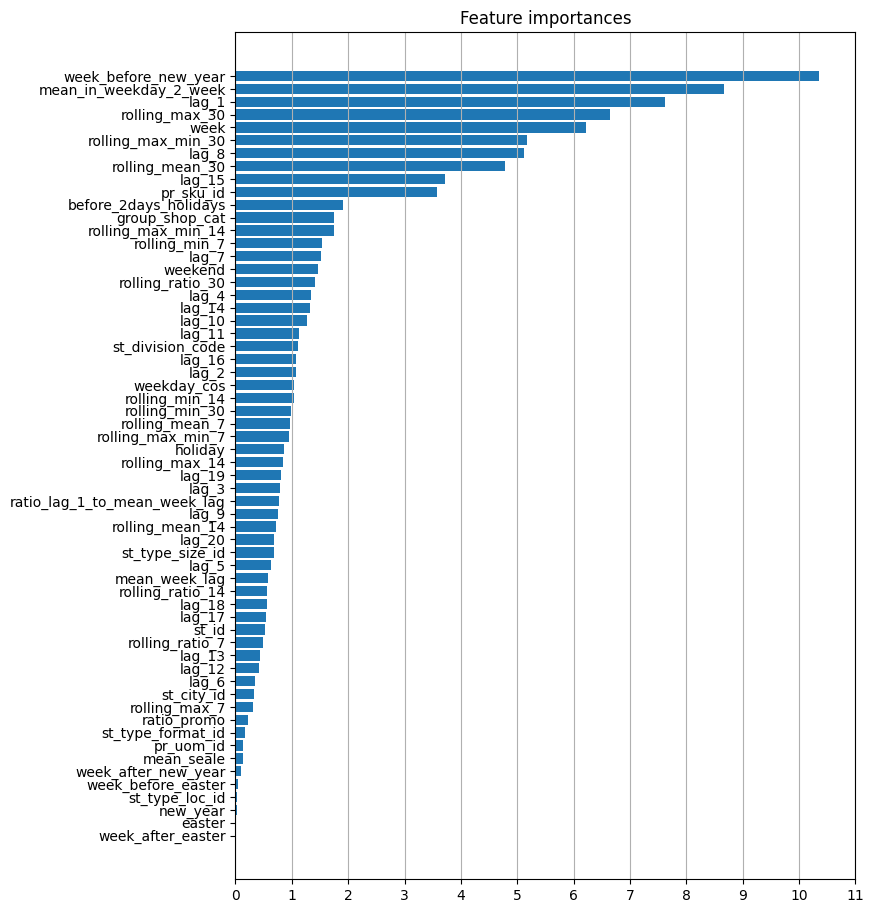

In [117]:
plt.figure(figsize=(8, 11))
plt.barh(df_importances['name_feature'], df_importances['importances'])
plt.title('Feature importances')
plt.xticks(range(0, 12))
plt.grid(axis = 'x')
plt.show()

Из анализа видно, что большинство признаков оказывают то или иное влияние на прогноз, но есть признаки влияние которых минимально (в частности всё что связано с пасхой). Вероятнее всего это связано с тем, что все товары, на которые был большой спрос в пасху проходили по промо и модель их вообще не видела.

Выведем топ 15 наиболее значащих признаков

In [119]:
df_importances.sort_index().loc[:15]

,name_feature,importances
0,week_before_new_year,10.354115
1,mean_in_weekday_2_week,8.662080
2,lag_1,7.611816
3,rolling_max_30,6.651357
4,week,6.219683
5,rolling_max_min_30,5.178042
6,lag_8,5.110290
7,rolling_mean_30,4.789770
8,lag_15,3.711949
9,pr_sku_id,3.579302


Самое сильное влияние на прогноз оказывает Признак недели перед новым годом (поскольку в этот период идёт очень большой спрос). Так же отдельно  выделяются признаки соответствующих дней (среднее в конкретний день недели за последнии джве недели, лаг 1 (по факту лаг 13 + 1), лаг 8 (по факту лаг 8 + 13), лаг 15 (15 + 13). Плюс скользящие за 30 дней (максимальное, среднее и отношение макусимального к минимальному). Так же к сильным признакам можно отнести номер недели преобразованный через косинус.

Следует обратить внимание, что все признаки генерируются со смещением в 13 дней + смещение конкретного признака.

## Создание прогноза на кросс валидации.

Сделаем кроссвалидационный прогноз нашей модели. Для начала получим данные до конца тестового отрезка (у нас останется отложеная выборка для финального теста модели)

In [120]:
df_train = pd.read_csv(PATH_TO_SAVE_TRAIN_DF, parse_dates=['date'], index_col='date')
df_train = df_train.loc[: valid_start_date - timedelta(days=1)]

Далее воспользуемся написанной ранее функцией для получения фолдов для кросс-валидации (будем использовать 5 фолдов)

In [128]:
folds = get_folds(df, 10)

Напишем функцию, которая будет обучать модель, делать прогноз и возвращать датафрейм для дальнейшей визуализации

In [129]:
def train_predict(df_train, df_test):
    X_train = df_train.drop('target', axis=1)
    y_train = df_train['target'] 

    model = CatBoostRegressor(random_state=123,
                              cat_features=cat_columns,
                              max_depth = 8,
                              n_estimators = 1000,
                              thread_count = -1,
                              verbose=False)
    
    model.fit(X_train, y_train)
    
    new_df = df_test[['pr_sku_id', 'st_id']].reset_index(drop=True)
    new_df['date'] = df_test.index

    y_pred = model.predict(df_test.drop('target', axis=1))    
    
    df_test_true = df_test[['pr_sku_id', 'st_id', 'target']]
    df_test_true = df_test_true.reset_index(drop=False)
    df_test_true = df_test_true.rename(columns={'target': 'y_true'})
    
    new_df['target'] = y_pred
    new_df = new_df.merge(df_test_true, on=['date', 'pr_sku_id', 'st_id'], how='right')
    new_df = new_df.fillna(0)
    return new_df

Теперь создадим функцию, которая будет осуществлять кросвалидацию, по каждому фолду рассчитывать wape и возвращать 2 датафрейма: один с прогнозом, второй с wape.

In [130]:
def get_cv_predict_and_info(df, folds):
    list_wape = []
    list_pred = []
    for fold in tqdm(folds):
        df_pred = train_predict(df_train.iloc[fold[0]], df_train.iloc[fold[1]])
        list_pred.append(df_pred)
        df_wape = pd.DataFrame({'date_predict': [df_pred['date'].min()],
                                'wape': [wape(df_pred['y_true'], df_pred['target'])]})
        list_wape.append(df_wape)
        
    new_df_pred = pd.concat(list_pred, axis=0).sort_values('date')
    new_df_wape = pd.concat(list_wape, axis=0).sort_values('date_predict')
    return new_df_pred, new_df_wape

In [131]:
df_pred, df_wape = get_cv_predict_and_info(df_train, folds)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [29:46<00:00, 178.68s/it]


Получим из трейновых данных те, которые не вошли в прогноз, чтобы построить первую часть графика

In [132]:
df_for_graf = df_train.loc[:df_pred['date'].min() - timedelta(days=1), ['st_id', 'pr_sku_id', 'target']]
df_for_graf = df_for_graf.rename(columns={'target': 'y_true'}).reset_index(drop=False)

In [133]:
df_for_graf = pd.concat([df_for_graf, df_pred], axis=0)

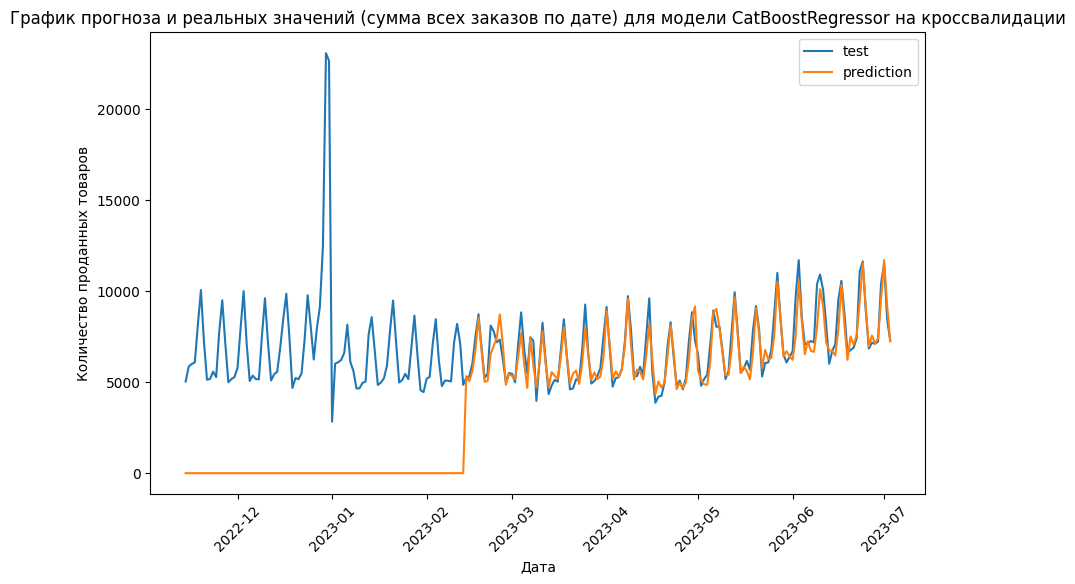

In [134]:
visualize_pred(df_for_graf, 'CatBoostRegressor на кроссвалидации')

Построим график качества прогноза в зависимости от даты соввершения прогноза

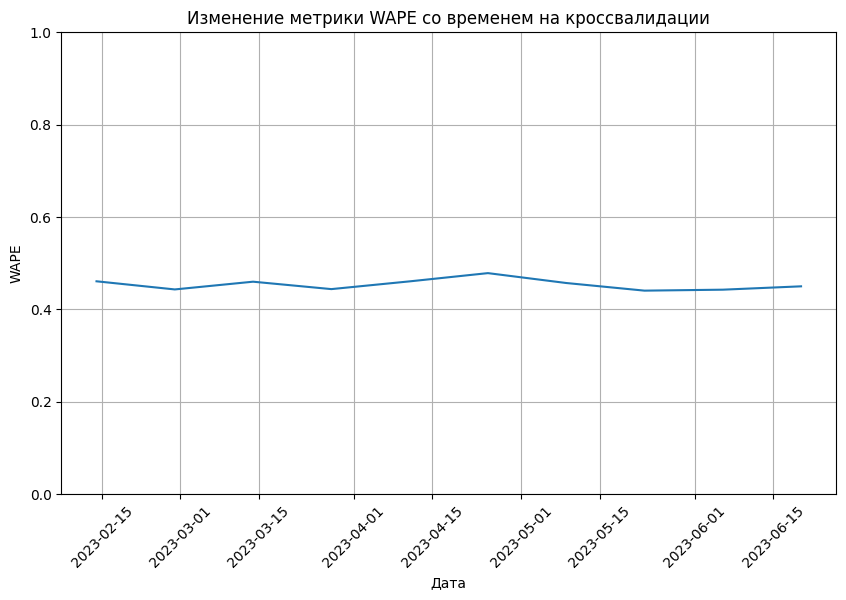

In [151]:
df_wape.index = df_wape['date_predict']
plt.figure(figsize=(10, 6))
plt.title('Изменение метрики WAPE со временем на кроссвалидации')
plt.plot(df_wape['wape'])
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('WAPE')
plt.grid()
plt.show()

Проверка на кроссвалидации показала, что модель достаточно стабильна, хотя и имеет просадки в тех прогнозах, который делались на праздники, возможно это связано с тем, что модели не хватает таких образцов в течении одного года, чтобы обобщить закономерности, либо ей требуются дополнительные признаки.

## Проверка на отложенной выборке

Поскольку у нас изменилисьнекоторые параметры генерации признаков, то заново получим датасеты для отложенной выбори.

In [155]:
sales_df_train = pd.read_csv(PATH_SALES_DF_TRAIN)
pr_df = pd.read_csv(PATH_PR_DF)
st_df = pd.read_csv(PATH_ST_DF)

In [177]:
date = sales_df_train['date'].max()
first_date = datetime.strptime(date, '%Y-%m-%d') - timedelta(days = 14)
first_date = datetime.strftime(first_date, '%Y-%m-%d')

In [178]:
%%time
df_test = preproceccing_df(sales_df_train, 
                           pr_df, 
                           st_df,
                           first_date,
                           list_holidays = list_holidays, 
                           is_train=False,
                           **df_best_dict)

CPU times: total: 5min 43s
Wall time: 5min 43s


In [179]:
%%time
df_train_test = preproceccing_df(sales_df_train, 
                               pr_df, 
                               st_df,
                               first_date,
                               list_holidays = list_holidays, 
                               is_train=True,
                               **df_best_dict)

CPU times: total: 5min 23s
Wall time: 5min 23s


Обучим модель.

In [180]:
cat_columns = ['st_id', 'pr_sku_id', 'st_city_id', 'st_division_code',
       'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'mean_seale',
       'pr_uom_id', 'group_shop_cat']

X_train = df_train_test.drop('target', axis=1)
y_train = df_train_test['target'] 

model = CatBoostRegressor(random_state=123,
                              cat_features=cat_columns,
                              max_depth = 8,
                              n_estimators = 1000,
                              thread_count = -1,
                              verbose=False)

model.fit(X_train, y_train)

Получим датасет с предсказаниями.

In [181]:
new_df = df_test[['pr_sku_id', 'st_id']].reset_index(drop=True)
new_df['date'] = pd.to_datetime(df_test.index)

X_test = df_test.drop('target', axis=1)
y_pred = model.predict(X_test)
new_df['target'] = y_pred

Присоединим данные из обработанного датасета по прогнозам, чтобы сделать визуализацию.

In [182]:
df_for_pred = pd.read_csv(PATH_TO_SAVE_TRAIN_DF)[['pr_sku_id', 'st_id', 'date', 'target']]
df_for_pred['date'] = pd.to_datetime(df_for_pred['date'])
df_for_pred = df_for_pred[(df_for_pred['date']>= new_df['date'].min()) &
                          (df_for_pred['date']<= new_df['date'].max())]
df_for_pred = df_for_pred.rename(columns = {'target': 'y_true'})
new_df = new_df.merge(df_for_pred, on=['date', 'pr_sku_id', 'st_id'], how='right')
new_df = new_df.fillna(0)

In [183]:
wape(new_df['y_true'], new_df['target'])

0.45246402851216955

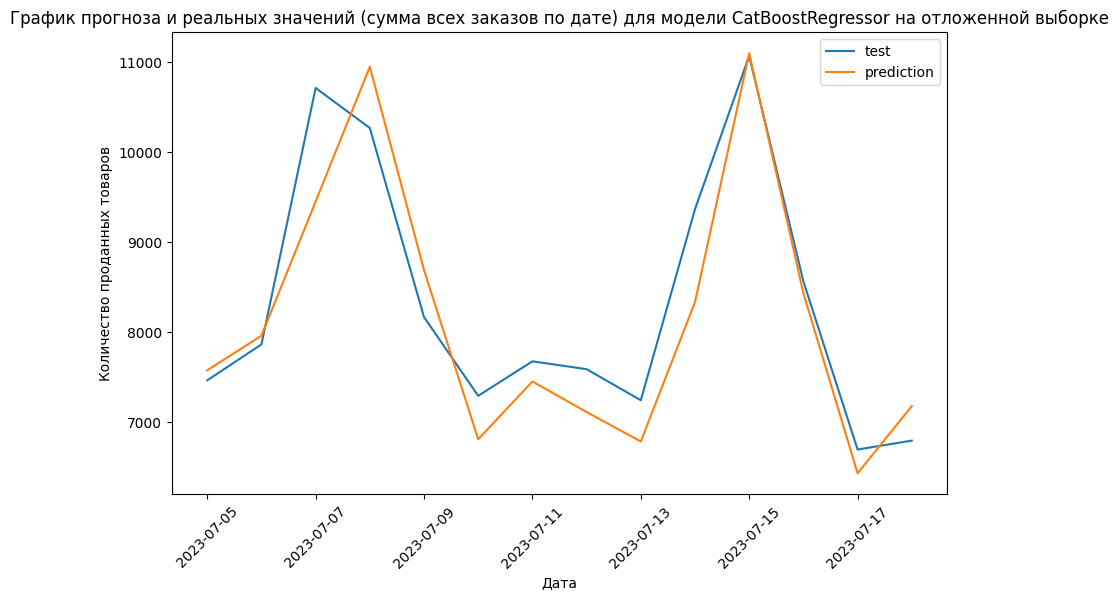

In [185]:
visualize_pred(new_df, 'CatBoostRegressor на отложенной выборке')

Учитывая, что при предобработке данных некоторые данные могли отбрасываться, то посмотрим как будет вести себя метрика на сырых данных. Заново сформируем датасет с прогнозом.

In [186]:
new_df = df_test[['pr_sku_id', 'st_id']].reset_index(drop=True)
new_df['date'] = df_test.index

X_test = df_test.drop('target', axis=1)
y_pred = model.predict(X_test)
new_df['target'] = y_pred

In [187]:
df_for_pred = pd.read_csv(PATH_SALES_DF_TRAIN)[['st_id', 'pr_sales_type_id', 'pr_sku_id', 'date', 'pr_sales_in_units']]
df_for_pred['date'] = pd.to_datetime(df_for_pred['date'])
df_for_pred = df_for_pred[(df_for_pred['date']>= new_df['date'].min()) &
                          (df_for_pred['date']<= new_df['date'].max())]
df_for_pred = df_for_pred[df_for_pred['pr_sales_type_id']==0]
df_for_pred = df_for_pred.drop('pr_sales_type_id', axis=1)
df_for_pred = df_for_pred.rename(columns = {'pr_sales_in_units': 'y_true'})

new_df = new_df.merge(df_for_pred, on=['date', 'pr_sku_id', 'st_id'], how='right')
new_df = new_df.fillna(0)

In [188]:
wape(new_df['y_true'], new_df['target'])

0.4514548662946493

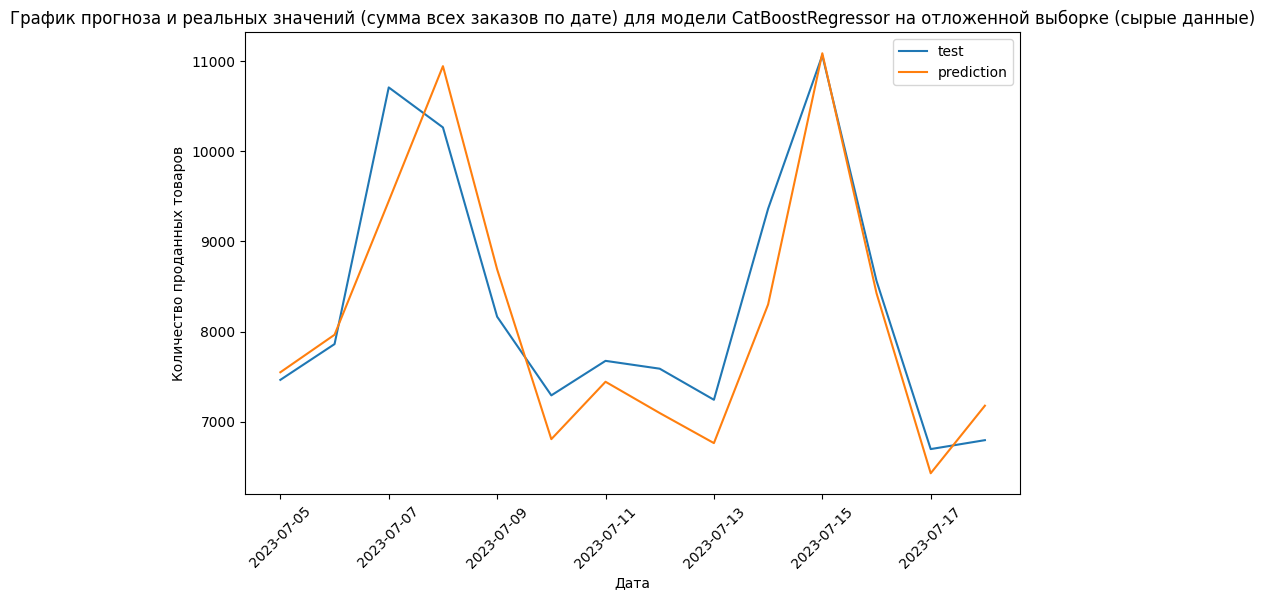

In [192]:
visualize_pred(new_df, 'CatBoostRegressor на отложенной выборке (сырые данные)')

На отложенной выборке модель показала сопостовимое качество метрики, что говорит о стабильности модели.

## Прогнозирование спроса на сбмите

Откроем датасет с запросом товаров для прогноза

In [200]:
sumissions_df = pd.read_csv(PATH_TO_SUMISSION_DF)

Получим датасет для получения прогноза (т.к. мы явно не передаём дату, то заготовка для прогноза будет строится на 14 дней от последней даты)

In [195]:
df_pred = preproceccing_df(sales_df_train, 
                           pr_df, 
                           st_df,
                           list_holidays = list_holidays, 
                           is_train=False,
                           **df_best_dict)

Загрузим трейнировочный датасет в полном объёме и переобучим нашу модель на всех доступных данных.

In [194]:
df_train = pd.read_csv(PATH_TO_SAVE_TRAIN_DF, parse_dates=['date'], index_col='date')

X_train = df_train.drop('target', axis=1)
y_train = df_train['target'] 

model = CatBoostRegressor(random_state=123,
                          cat_features=cat_columns,
                          max_depth = 8,
                          n_estimators = 1000,
                          thread_count = -1,
                          verbose=False)

model.fit(X_train, y_train)

Напишем функцию, которая на вход будет принимать датасет для прогноза, модель и датасет с запросом, а возвращать датасет с прогнозом в требуемом формате. При этом предусмотрим возможность, не передовать конкретный датасет с запросом, в этом случае функция вернёт прогноз по всем уже известным пересечениям продукта и магазиан (для магазинов активных в настоящий момент).

In [205]:
def prediction_submitions(df_pred, model, sumissions_df=None):
    if sumissions_df is not None and 'target' in sumissions_df.columns:
        sumissions_df = sumissions_df.drop('target', axis = 1)
        
    new_df = df_pred[['pr_sku_id', 'st_id']].reset_index(drop=True)
    new_df['date'] = pd.to_datetime(df_pred.index)

    X_test = df_pred.drop('target', axis=1)
    y_pred = model.predict(X_test)
    new_df['target'] = y_pred
    
    if sumissions_df is not None:
        sumissions_df['date'] = pd.to_datetime(sumissions_df['date'])
        new_df = new_df.merge(sumissions_df, on=['date', 'pr_sku_id', 'st_id'], how='right')
        new_df = new_df.fillna(0)
    return new_df

In [207]:
sumissions = prediction_submitions(df_pred, model, sumissions_df)

Сохраним полученный прогноз. И обученную модель

In [208]:
sumissions.to_csv(PATH_TO_SAVE_SUMISSION_DF,index=False)

In [213]:
with open(PATH_TO_SAVE_MODELS, "wb") as f:
        pickle.dump(model, f)

## Общие выводы

В данном разделе была проведена работа по созданию модели машинного обучения и оценки её качества, в частности:
1. Создан baislain в виде наивной модели, которая прогнозирует спрос на уровне последнего известного проса
2. Разработан ансамбль моделей, каждый из которых прогназирует спрос для своего сегмента (сочетание категории товаров - группа магазинов). Данный алгоритм показал более высокий уровень чем baislain.
3. Написаны функции как для тренировки моделей, так и для получения предсказаний.
4. Оптимизированы признаки путём подбора наиболее эффективных значений.
5. Всё это позволило получить wape на валидационной и отложеной выборке меньше 0,8.

### Что ещё нужно сделать

В данной работе необходимо доделать (то на что не хватило времени):
1. Проработать группировку сочетания категории товаров - группа магазинов, вероятно можно улучшить каечство прогноза оптимизировав группировку (при любой группировке всегда будет предел качества, в который уткнётся модель). Следовательно нужно опять проработать EDA.
2. Поэкспериментировать с Catboostom, возможно он сможет дать лучшее качество модели.
3. Сделать предварительную генерацию признаков при помощи Propheta.
4. Провести подбор гиперпараметров на кроссвалидации (оптимально, если бы были данные за предыдущие года, чтобы модель научилась предсказывать годовую сезонность).